## 12-1 시계열 탐색적 분석

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

ts = pd.read_csv('./data/12_covid19.csv', encoding= 'cp949')
ts = ts[['날짜', '전일대비증감수']]
ts['날짜'] = ts['날짜'].astype('datetime64[ns]') # 날짜 데이터로 설정
ts = ts.set_index('날짜')
ts_head = ts.head(334)
ts_tail = ts.tail(31)
ts_head

,전일대비증감수
날짜,
2021-01-01,357
2021-01-02,250
2021-01-03,198
2021-01-04,329
2021-01-05,199
...,...
2021-11-26,1742
2021-11-27,1888
2021-11-28,1676


일반적 EDA

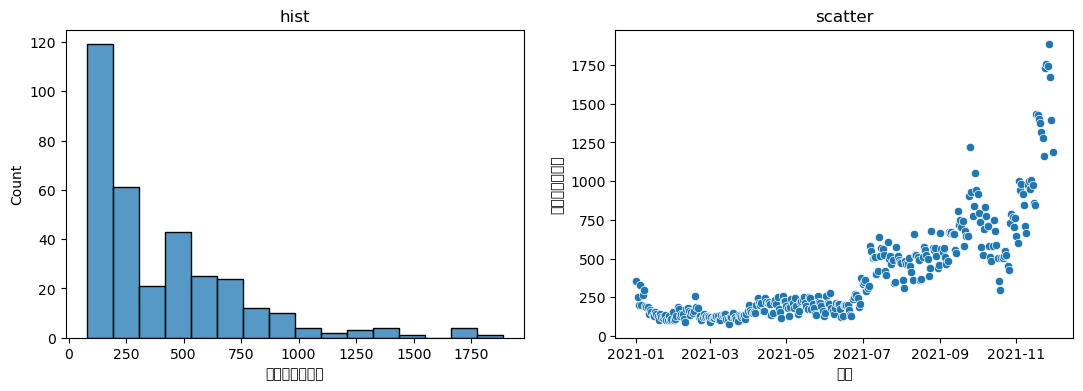

         count        mean         std   min    25%    50%    75%     max
전일대비증감수  334.0  405.152695  336.013188  79.0  152.0  252.5  556.0  1888.0


In [17]:
import seaborn as sns
import warnings
warnings.filterwarnings(action= 'ignore')

fig, axes = plt.subplots(1,2, figsize = (13,4))

axes[0].set_title('hist')
sns.histplot(x = '전일대비증감수', data = ts_head, ax = axes[0])

axes[1].set_title('scatter')
sns.scatterplot(x = '날짜', y = '전일대비증감수', data= ts_head, ax = axes[1])
plt.show()

print(ts_head.describe().T)

시계열에 특화된 EDA

> 정상성 확인

In [19]:
# 정상성 검정1 - ADF
# H0 : 단위근을 포함한다 (비정상)
# H1 : 단위근을 포함하지 않는다 (정상)

from statsmodels.tsa.stattools import adfuller
result = adfuller(ts_head, regression= 'c', autolag='AIC')
print('ADF 검정통계량 :{}, pvalue : {}'.format(result[0], result[1]))

# ts_head 는 비정상 시계열 데이터이다.

ADF 검정통계량 :0.7623135388299536, pvalue : 0.9910028277484191


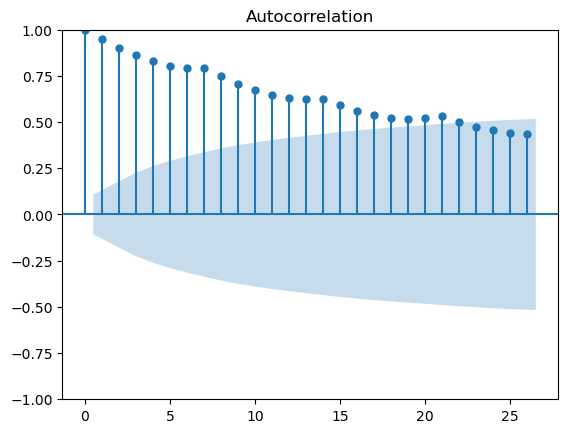

In [22]:
# 정상성 검정2 - KPSS
# 정상성 검정3 - ACF 그래프
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ts_head)
plt.show() # 시차에 따라 값이 빠르게 떨어지지 않기 때문에 비정상 시계열이라는 결론

> 자기상관확인(AR)

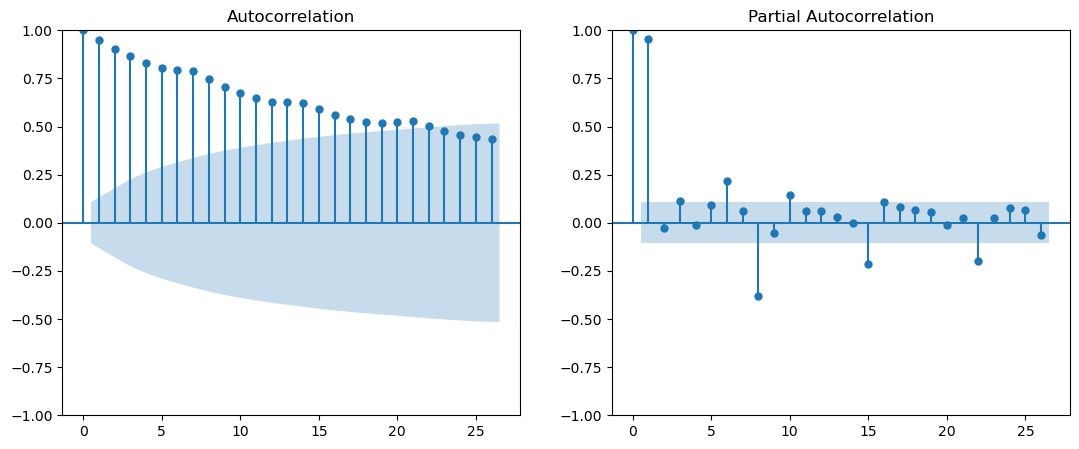

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

# 자기상관 검정1 - ACF/PACF 그래프

fig, ax = plt.subplots(1,2, figsize = (13,5))
plot_acf(ts_head, ax = ax[0])
plot_pacf(ts_head, ax = ax[1])
plt.show()

# ACF 그래프의 임계영역을 벗어나는 값들을 볼 때, 자기 상관이 있음을 알 수 있다.
# PACF 그래프의 임계영역을 벗어나는 시차 1,3,6,8 등이 자기 상관이 있음

In [29]:
# 자기상관 검정2 - Ljung-box test
# H0 : 데이터가 일련의 상관관계가 없다
# H1 : 데이터가 일련의 상관관계가 있다
from statsmodels.stats.diagnostic import acorr_ljungbox
print('융박스 테스트')

result = acorr_ljungbox(ts_head, return_df = True, auto_lag= True)
print(result)

# 데이터가 상관관계가 있다는 결론

융박스 테스트
          lb_stat      lb_pvalue
1      304.691106   3.131578e-68
2      579.605498  1.381228e-126
3      833.394832  2.474556e-180
4     1067.333259  9.111938e-230
5     1286.641140  5.005454e-276
..            ...            ...
327  18675.618923   0.000000e+00
328  18688.620396   0.000000e+00
329  18698.628106   0.000000e+00
330  18704.259818   0.000000e+00
331  18708.005461   0.000000e+00

[331 rows x 2 columns]


In [31]:
# 자기상관 검정3 - Durbin-watson test
# 통계량이 2에 가까우면 자기 상관이 없다.
# 통계량이 0 또는 4에 가까우면 자기 상관이 있다.

from statsmodels.stats.stattools import durbin_watson
result = durbin_watson(ts_head)
print(result)

[0.03337102]


> 시계열 분해

+ 이동평균법 : 계절 변동과 불규칙 변동을 제거
+ 지수평활법 : 불규칙 변동 제거

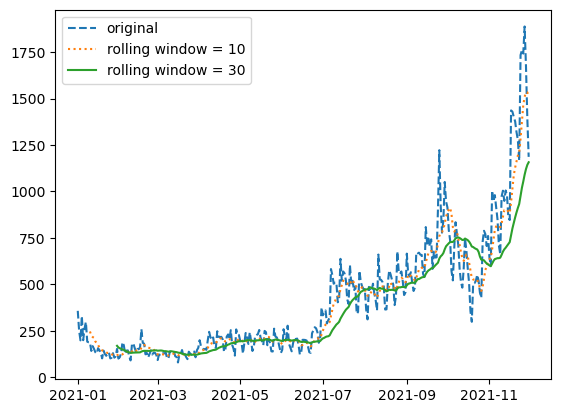

In [32]:
# 이동평균법 : 계절 변동과 불규칙 변동 제거
fig, ax = plt.subplots(1,1)

titles = ['original', 'rolling window = 10', 'rolling window = 30']
rw10 = ts_head.rolling(window = 10).mean().dropna()
rw30 = ts_head.rolling(window = 30).mean().dropna()
data_list = [ts_head, rw10, rw30]
ls_list = ['dashed', 'dotted', 'solid']

for title, data, ls in zip(titles, data_list, ls_list):
    ax.plot(data, label = title, linestyle = ls)

plt.legend()
plt.show()